# Imports and setup

In [1]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math
import pandas as pd
import matplotlib.pyplot as plt

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, classification_report)

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


In [ ]:

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

### Step 1: Preprocess and Save Processed Data to CSV 

##### Functions to preprocess data

In [12]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}  # Define your custom stopwords here
    stop_words.update(custom_stopwords)
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

def check_data_leakage(X_train, X_test):
    train_set = set(map(tuple, X_train))
    test_set = set(map(tuple, X_test))

    leaked_samples = train_set.intersection(test_set)
    print("\n🔍 Checking Data Leakage...")
    print(f"⚠️ {len(leaked_samples)} samples from test data are also in training data.")

    if len(leaked_samples) > 0:
        print("❌ Data Leakage Detected! Test data should not exist in training set.")
    else:
        print("✅ No Data Leakage Detected.")

##COMAPRES TEST ACCURACY TO TRAIN ACCURACY
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    print("\n🔍 Checking Overfitting...")
    print(f"📊 Training Accuracy: {train_acc:.4f}")
    print(f"📊 Test Accuracy: {test_acc:.4f}")

    if train_acc > test_acc + 0.10:
        print("❌ Possible Overfitting: Model performs much better on training data.")
    else:
        print("✅ No significant overfitting detected.")

# Line Chart (Trend over Repeats)
def plot_metric_trends(csv_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(8, 4))
    metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    for metric in metric_columns:
        plt.plot(df['Repeat'], df[metric], marker='o', label=metric)

    # Chart styling
    plt.xlabel("Repeat")
    plt.ylabel("Score")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(metric_columns), frameon=False)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


##### Download and read data, save to csv files for repeatable use

In [3]:
########## 3. Download & read data ##########
project = 'caffe'
text_col = 'Title+Body'


In [8]:
path = f'C:/Users/chibu/Documents/ISE-solution-main/Coursework/datasets/{project}.csv'

data = pd.read_csv(path).fillna('')
data['Title+Body'] = data.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
#text_col = 'Title+Body'

data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

data.to_csv(f'{project}_processed_data.csv', index=False)


##### Load and check datasets in Title+Body Files

In [4]:
baseline_path = 'C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2'

df = pd.read_csv(f'{project}_processed_data.csv')
df.head()

,Unnamed: 0,Repository,Number,State,Title,Body,Labels,Comments,Codes,Commands,class,related,Title+Body
0,0,caffe,3075,closed,strange result when running blvc_reference_caf...,"Hi,\n\nI tried to run the example here: https:...",NaN,"[""You need to do\nout['prob'].argmax(axis=1)\n...",[],[],1,0,strange result running blvc reference caffenet...
1,1,caffe,4102,closed,Change the batch_size by the method Reshape(),I used a deploy.prototxt to initialize a new n...,NaN,['One probably reason I found in the code is :...,"['\ninput: ""data""\ninput_shape {\n dim: 256\n...",[],1,0,change batch size method reshape( ) . used dep...
2,2,caffe,5643,open,Convert caffemodel into C++/python scripts to ...,"Hi all, I have a question to discuss with anyo...",NaN,"[""No that won't help you get more speed. The C...",[],[],1,0,convert caffemodel c python scripts improve de...
3,3,caffe,3086,closed,PyCaffe backward() produces zero gradients whe...,I'm working on generating saliency maps though...,NaN,"[""Closing as there is not enough information h...","[""\nimport caffe\nimport numpy as np\ncaffe.se...",[],1,0,pycaffe backward( ) produces zero gradients gp...
4,4,caffe,2448,closed,CPU usage at a low level,Hi everyone. When I run Caffe with CPU usage c...,NaN,"[""@bearpaw Hey dude, are you using CPU only? M...",['\nI0512 22:09:43.043788 7012 caffe.cpp:273]...,[],1,0,cpu usage low level. hi everyone. run caffe cp...


### Step 2: Configure parameters and start training

##### Set values, params and load csv files

In [18]:
# Number of repeated experiments
REPEAT = 30

# Output CSV file name
results_dir = "C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2/results"
out_csv_name = f"{results_dir}/{project}_Results.csv"

# Convert and save metrics for all models
def save_model_metrics(metrics_list, filename):
    df = pd.DataFrame(metrics_list)
    df.to_csv(f"{results_dir}/{filename}", index=False)
    print(f"Saved: {filename}")
    print(df.mean(numeric_only=True))
    print("\n")

# Hyperparameter grid for Naive Bayes
params = {'var_smoothing': np.logspace(-12, 0, 13)}

# Lists to store metrics across repeated runs
accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

##### Perform Testing on Baseline code from Lab 1

In [11]:
nb_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X = data[text_col]
y = data['class']

for repeated_time in range(REPEAT):
    

    # Train-test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Train and Evaluate Naive Bayes with Cross-Validation
    nb_clf = GaussianNB()
    grid = GridSearchCV(nb_clf, params, cv=5, scoring='roc_auc')
    grid.fit(X_train_tfidf, y_train)
    best_nb = grid.best_estimator_
    y_pred_nb = best_nb.predict(X_test_tfidf)
    
    nb_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test, y_pred_nb),
        "Precision": precision_score(y_test, y_pred_nb, average='macro'),
        "Recall": recall_score(y_test, y_pred_nb, average='macro'),
        "F1": f1_score(y_test, y_pred_nb, average='macro'),
        "AUC": auc(*roc_curve(y_test, y_pred_nb, pos_label=1)[:2])
    })

    save_model_metrics(nb_metrics, f'{project}_NaiveBayes_Metrics.csv')

Saved: caffe_NaiveBayes_Metrics.csv
Repeat       0.000000
Accuracy     0.569767
Precision    0.513238
Recall       0.538462
F1           0.443220
AUC          0.538462
dtype: float64


Saved: caffe_NaiveBayes_Metrics.csv
Repeat       0.500000
Accuracy     0.715116
Precision    0.531928
Recall       0.534022
F1           0.488337
AUC          0.534022
dtype: float64


Saved: caffe_NaiveBayes_Metrics.csv
Repeat       1.000000
Accuracy     0.666667
Precision    0.542028
Recall       0.558675
F1           0.497081
AUC          0.558675
dtype: float64


Saved: caffe_NaiveBayes_Metrics.csv
Repeat       1.500000
Accuracy     0.633721
Precision    0.553653
Recall       0.592642
F1           0.494834
AUC          0.592642
dtype: float64


Saved: caffe_NaiveBayes_Metrics.csv
Repeat       2.000000
Accuracy     0.590698
Precision    0.549198
Recall       0.589554
F1           0.471446
AUC          0.589554
dtype: float64


Saved: caffe_NaiveBayes_Metrics.csv
Repeat       2.500000
Accuracy     0.58

##### View progressive results

In [12]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')
df.head() 

,Repeat,Accuracy,Precision,Recall,F1,AUC
0,0,0.569767,0.513238,0.538462,0.443220,0.538462
1,1,0.860465,0.550617,0.529582,0.533454,0.529582
2,2,0.569767,0.562229,0.607981,0.514569,0.607981
3,3,0.534884,0.588527,0.694545,0.488095,0.694545
4,4,0.418605,0.531378,0.577201,0.377894,0.577201


##### Save final results to csv file

In [13]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in nb_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in nb_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in nb_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in nb_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in nb_metrics])
}

save_model_metrics([final_metrics], f'{project}_NaiveBayes_Final_Metrics.csv')

Saved: caffe_NaiveBayes_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.550775
Avg_Precision     0.557756
Avg_Recall        0.640756
Avg_F1            0.464268
Avg_AUC           0.640756
dtype: float64




##### Load results for baseline 

In [14]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.550775,0.557756,0.640756,0.464268,0.640756


### Examine datasets for data leakage and overfitting and class ditribution to know what to expect when it comes to validating my results based on baseline

In [15]:


#check where these variables are coming from
# For baseline Naive Bayes testing:
check_data_leakage(X_train_tfidf, X_test_tfidf)
check_overfitting(best_nb, X_train_tfidf, y_train, X_test_tfidf, y_test)

print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.7500
📊 Test Accuracy: 0.5116
❌ Possible Overfitting: Model performs much better on training data.

Class Distribution in Training Set:
class
0    173
1     27
Name: count, dtype: int64

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        80
           1       0.12      1.00      0.22         6

    accuracy                           0.51        86
   macro avg       0.56      0.74      0.43        86
weighted avg       0.94      0.51      0.61        86



##### Line chart for repeats

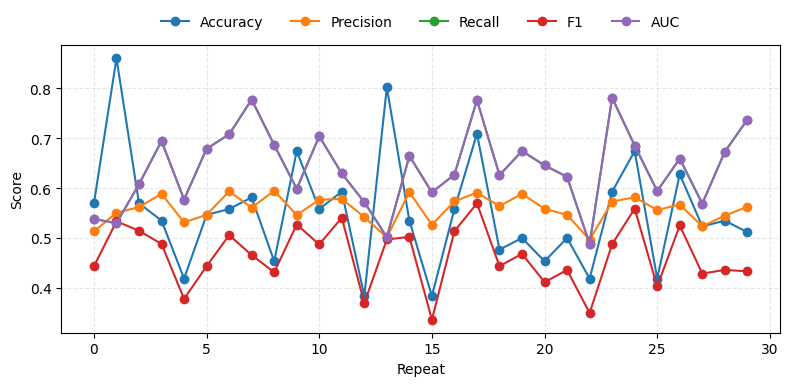

In [13]:
plot_metric_trends(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')

##### Perform Testing with Random Forest

In [28]:
rf_metrics = []

# Load dataset for this iteration
data_rf = pd.read_csv(f'{project}_processed_data.csv')
X_rf = data_rf[text_col]
y_rf = data_rf['class']

for repeated_time in range(REPEAT):
    
    # Train-test split (70/30)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
        X_rf, y_rf, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf_rf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_rf = tfidf_rf.fit_transform(X_train_rf).toarray()
    X_test_tfidf_rf = tfidf_rf.transform(X_test_rf).toarray()

    # Train and Evaluate Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf.fit(X_train_tfidf_rf, y_train_rf)
    y_pred_rf = rf_clf.predict(X_test_tfidf_rf)

    rf_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_rf, y_pred_rf),
        "Precision": precision_score(y_test_rf, y_pred_rf, average='macro'),
        "Recall": recall_score(y_test_rf, y_pred_rf, average='macro'),
        "F1": f1_score(y_test_rf, y_pred_rf, average='macro'),
        "AUC": auc(*roc_curve(y_test_rf, y_pred_rf, pos_label=1)[:2])
    })

    precision = precision_score(y_test_rf, y_pred_rf, average='macro', zero_division=0)
    print(f"Repeat {repeated_time}: Precision = {precision}")

save_model_metrics(rf_metrics, f'{project}_RandomForest_Metrics2.csv')


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 0: Precision = 0.45348837209302323
Repeat 1: Precision = 0.4476744186046512


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 2: Precision = 0.4127906976744186
Repeat 3: Precision = 0.436046511627907
Repeat 4: Precision = 0.4457831325301205
Repeat 5: Precision = 0.9705882352941176


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 6: Precision = 0.436046511627907
Repeat 7: Precision = 0.47093023255813954


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 8: Precision = 0.436046511627907
Repeat 9: Precision = 0.4418604651162791
Repeat 10: Precision = 0.9529411764705882
Repeat 11: Precision = 0.4069767441860465


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 12: Precision = 0.43023255813953487
Repeat 13: Precision = 0.45930232558139533


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 14: Precision = 0.4186046511627907
Repeat 15: Precision = 0.46511627906976744


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 16: Precision = 0.4127906976744186
Repeat 17: Precision = 0.45930232558139533


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 18: Precision = 0.43023255813953487
Repeat 19: Precision = 0.43023255813953487


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 20: Precision = 0.4476744186046512
Repeat 21: Precision = 0.4476744186046512


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 22: Precision = 0.45930232558139533
Repeat 23: Precision = 0.46511627906976744


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 24: Precision = 0.4418604651162791
Repeat 25: Precision = 0.9294117647058824


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Repeat 26: Precision = 0.4418604651162791
Repeat 27: Precision = 0.9588235294117646
Repeat 28: Precision = 0.46511627906976744
Repeat 29: Precision = 0.46511627906976744
Saved: caffe_RandomForest_Metrics2.csv
Repeat       14.500000
Accuracy      0.888372
Precision     0.511298
Recall        0.507346
F1            0.484393
AUC           0.507346
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save results to csv file

In [17]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in rf_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in rf_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in rf_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in rf_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in rf_metrics])
}

save_model_metrics([final_metrics], f'{project}_RandomForest_Final_Metrics.csv')

Saved: caffe_RandomForest_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.887984
Avg_Precision     0.494465
Avg_Recall        0.506064
Avg_F1            0.481915
Avg_AUC           0.506064
dtype: float64




##### Load results for Random Forest 

In [18]:
df = pd.read_csv(f'{baseline_path}/results/{project}_RandomForest_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.887984,0.494465,0.506064,0.481915,0.506064


##### Line chart Repeats

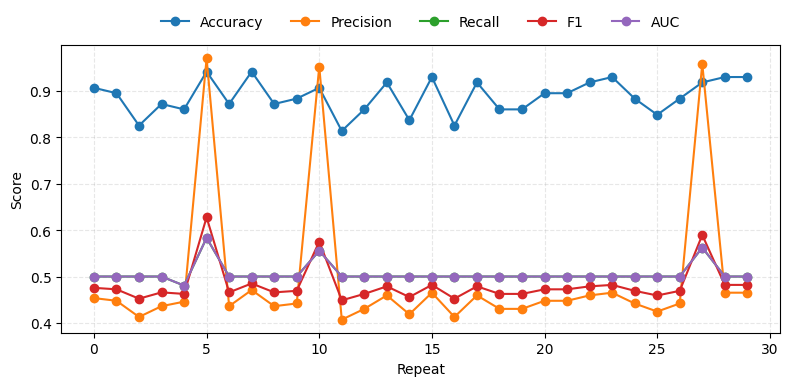

In [14]:
plot_metric_trends(f'{baseline_path}/results/{project}_RandomForest_Metrics.csv')

##### My own improvement: perform testing with the hybrid Model 

In [19]:
hybrid_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X_hybrid = data[text_col]
y_hybrid = data['class']

for repeated_time in range(REPEAT):
    

    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid, y_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[('rf', rf_clf_hybrid), ('logreg', logreg_clf_hybrid)], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

    save_model_metrics(hybrid_metrics, f'{project}_HybridModel_Metrics.csv')


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       0.000000
Accuracy     0.906977
Precision    0.453488
Recall       0.500000
F1           0.475610
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       0.500000
Accuracy     0.901163
Precision    0.450581
Recall       0.500000
F1           0.474001
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       1.000000
Accuracy     0.875969
Precision    0.437984
Recall       0.500000
F1           0.466744
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       1.500000
Accuracy     0.875000
Precision    0.437500
Recall       0.500000
F1           0.466518
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       2.000000
Accuracy     0.879070
Precision    0.439535
Recall       0.500000
F1           0.467693
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       2.500000
Accuracy     0.887597
Precision    0.443798
Recall       0.500000
F1           0.470065
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       3.000000
Accuracy     0.885382
Precision    0.442691
Recall       0.500000
F1           0.469461
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       3.500000
Accuracy     0.892442
Precision    0.446221
Recall       0.500000
F1           0.471407
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       4.000000
Accuracy     0.890181
Precision    0.445090
Recall       0.500000
F1           0.470789
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       4.500000
Accuracy     0.889535
Precision    0.444767
Recall       0.500000
F1           0.470623
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       5.000000
Accuracy     0.890063
Precision    0.445032
Recall       0.500000
F1           0.470784
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       5.500000
Accuracy     0.883721
Precision    0.441860
Recall       0.500000
F1           0.468945
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       6.000000
Accuracy     0.881932
Precision    0.440966
Recall       0.500000
F1           0.468450
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       6.500000
Accuracy     0.884551
Precision    0.442276
Recall       0.500000
F1           0.469188
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       7.000000
Accuracy     0.881395
Precision    0.440698
Recall       0.500000
F1           0.468289
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       7.500000
Accuracy     0.884448
Precision    0.442224
Recall       0.500000
F1           0.469141
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       8.000000
Accuracy     0.880985
Precision    0.440492
Recall       0.500000
F1           0.468146
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       8.500000
Accuracy     0.883075
Precision    0.441537
Recall       0.500000
F1           0.468737
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       9.000000
Accuracy     0.881885
Precision    0.440942
Recall       0.500000
F1           0.468409
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       9.500000
Accuracy     0.880814
Precision    0.440407
Recall       0.500000
F1           0.468114
AUC          0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       10.000000
Accuracy      0.881506
Precision     0.440753
Recall        0.500000
F1            0.468317
AUC           0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       10.500000
Accuracy      0.882135
Precision     0.441068
Recall        0.500000
F1            0.468503
AUC           0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       11.000000
Accuracy      0.883721
Precision     0.441860
Recall        0.500000
F1            0.468950
AUC           0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       11.500000
Accuracy      0.885659
Precision     0.442829
Recall        0.500000
F1            0.469491
AUC           0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       12.000000
Accuracy      0.885581
Precision     0.442791
Recall        0.500000
F1            0.469476
AUC           0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       12.500000
Accuracy      0.884168
Precision     0.442084
Recall        0.500000
F1            0.469078
AUC           0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       13.000000
Accuracy      0.884152
Precision     0.442076
Recall        0.500000
F1            0.469080
AUC           0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_HybridModel_Metrics.csv
Repeat       13.500000
Accuracy      0.884967
Precision     0.442483
Recall        0.500000
F1            0.469313
AUC           0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       14.000000
Accuracy      0.886528
Precision     0.443264
Recall        0.500000
F1            0.469748
AUC           0.500000
dtype: float64


Saved: caffe_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.887984
Precision     0.443992
Recall        0.500000
F1            0.470154
AUC           0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save results to csv file

In [20]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_HybridModel_Final_Metrics.csv')

Saved: caffe_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.887984
Avg_Precision     0.443992
Avg_Recall        0.500000
Avg_F1            0.470154
Avg_AUC           0.500000
dtype: float64




##### Load results for Hybrid Model 

In [21]:
df = pd.read_csv(f'{baseline_path}/results/{project}_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.887984,0.443992,0.5,0.470154,0.5


##### Line chart across repeats

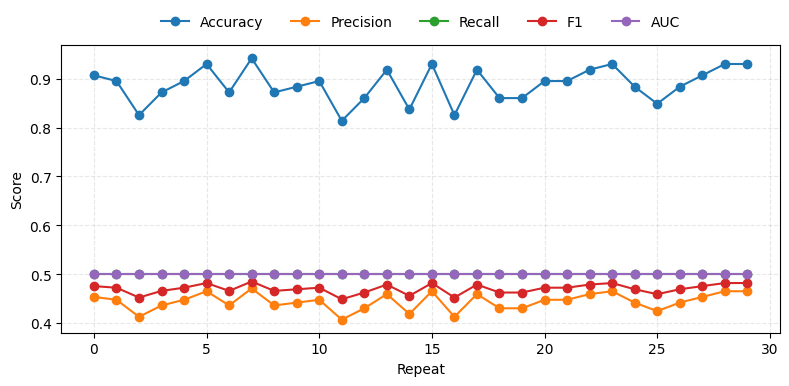

In [29]:
plot_metric_trends(f'{baseline_path}/results/{project}_HybridModel_Metrics.csv')

### Step 3: Validate results

###### Now that the training has been complete with the baselineto be able to compare with my own improvements. 
###### I want to ensure my results can be trusted so, FOR THE HYBRID MODEL, I will test on holdout data, check for data leakage an overfitting. I will also check the class distribution of the training set and perfrom SMOTE to Balance the dataset and retest witht the hybrid model, to see if there any differences in results

##### Test Hybrid Model on Holdout Data ---Shoukld this repeat 30 times???

In [22]:
###0 IS A NONBUG, SO IT IS WHAT SHOULD BE PRE4DICTED AS NONBUG

# Define function to test trained hybrid model on holdout set
def test_on_holdout_hybrid(model):
    holdout_data_hybrid = pd.read_csv(f'{project}_processed_data_holdout.csv')
    holdout_text_hybrid = holdout_data_hybrid[text_col]
    holdout_labels_hybrid = holdout_data_hybrid['class']

    tfidf_hybrid_holdout = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_holdout_hybrid = tfidf_hybrid_holdout.fit_transform(holdout_text_hybrid).toarray()

    holdout_preds_hybrid = model.predict(X_holdout_hybrid)
    print("\n🔍 Holdout Set Performance (Hybrid Model):")
    print(classification_report(holdout_labels_hybrid, holdout_preds_hybrid, target_names=['Non-Bug', 'Bug']))

    # Load full processed dataset
data = pd.read_csv(f'{project}_processed_data.csv')

# Create holdout split (90% train/test, 10% holdout)
train_test_data, holdout_data = train_test_split(data, test_size=0.1, random_state=42)

# Save to CSV for consistent usage across notebooks
train_test_data.to_csv(f'{project}_processed_train_test_data_holdout.csv', index=False)
holdout_data.to_csv(f'{project}_processed_data_holdout.csv', index=False)




hybrid_holdout_metrics = []

# Load 90% dataset for training/testing splits
data_hybrid_holdout = pd.read_csv(f'{project}_processed_train_test_data_holdout.csv')
X_hybrid_holdout = data_hybrid_holdout[text_col]
y_hybrid_holdout = data_hybrid_holdout['class']

for repeated_time in range(REPEAT):
    # Split into 70/30
    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid_holdout, y_hybrid_holdout, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF
    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    # Random Forest
    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    # Hybrid Model: Random Forest + Logistic Regression
    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[
        ('rf', rf_clf_hybrid), 
        ('logreg', logreg_clf_hybrid)
    ], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)
    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    # Save metrics for each repeat
    hybrid_holdout_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

# Save all repeated metrics to CSV
#save_model_metrics(hybrid_holdout_metrics, f'{project}_HybridModel_Holdout_Metrics.csv')



# Evaluate on true holdout portion
test_on_holdout_hybrid(voting_clf_hybrid)


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: Unde


🔍 Holdout Set Performance (Hybrid Model):
              precision    recall  f1-score   support

     Non-Bug       0.93      1.00      0.96        27
         Bug       0.00      0.00      0.00         2

    accuracy                           0.93        29
   macro avg       0.47      0.50      0.48        29
weighted avg       0.87      0.93      0.90        29



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: Unde

##### Save results to csv file

In [23]:
## Save results here

##### Load results for test on holdout

In [24]:
#df = pd.read_csv("processed_data_holdout.csv")
#df.head() 

##### Check for data leakage and overfitting

In [25]:
#check where these variables are coming from
check_data_leakage(X_train_tfidf_hybrid, X_test_tfidf_hybrid)
check_overfitting(voting_clf_hybrid, X_train_tfidf_hybrid, y_train_hybrid, X_test_tfidf_hybrid, y_test_hybrid)


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.8939
📊 Test Accuracy: 0.8846
✅ No significant overfitting detected.


##### Check class distribution 

In [26]:
print("\nClass Distribution in Training Set:")
print(y_train_hybrid.value_counts())
print("\nClassification Report:")
print(classification_report(y_test_hybrid, y_pred_hybrid))


Class Distribution in Training Set:
class
0    157
1     22
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        69
           1       0.00      0.00      0.00         9

    accuracy                           0.88        78
   macro avg       0.44      0.50      0.47        78
weighted avg       0.78      0.88      0.83        78



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Perform Smote to Balance Dataset and Test Hybrid Model 

In [27]:
smote_hybrid_metrics = []

# Load dataset for SMOTE-based training
data_smote_hybrid = pd.read_csv(f'{project}_processed_data.csv')
X_smote_hybrid = data_smote_hybrid[text_col]
y_smote_hybrid = data_smote_hybrid['class']

for repeated_time in range(REPEAT):
    # Train-test split (70/30)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
        X_smote_hybrid, y_smote_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF vectorization
    tfidf_smote = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_smote = tfidf_smote.fit_transform(X_train_smote).toarray()
    X_test_tfidf_smote = tfidf_smote.transform(X_test_smote).toarray()

    # Train Hybrid Model
    rf_clf_smote = RandomForestClassifier(n_estimators=100, max_depth=20)
    logreg_clf_smote = LogisticRegression(max_iter=2000)
    hybrid_clf_smote = VotingClassifier(
        estimators=[('rf', rf_clf_smote), ('logreg', logreg_clf_smote)],
        voting='soft'
    )

    # Apply SMOTE to balance training data
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf_smote, y_train_smote)

    # Train on balanced data
    hybrid_clf_smote.fit(X_train_balanced, y_train_balanced)

    # Predict on original (unbalanced) test set
    y_pred_smote_hybrid = hybrid_clf_smote.predict(X_test_tfidf_smote)

    # Collect metrics
    smote_hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_smote, y_pred_smote_hybrid),
        "Precision": precision_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "Recall": recall_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "F1": f1_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_smote, y_pred_smote_hybrid, pos_label=1)[:2])
    })

# Save metrics after all repeats
save_model_metrics(smote_hybrid_metrics, f'{project}_SMOTE_HybridModel_Metrics.csv')


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: caffe_SMOTE_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.892636
Precision     0.720467
Recall        0.573950
F1            0.587670
AUC           0.573950
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save and load results

In [28]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in smote_hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in smote_hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in smote_hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in smote_hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in smote_hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_SMOTE_HybridModel_Final_Metrics.csv')

Saved: caffe_SMOTE_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.892636
Avg_Precision     0.720467
Avg_Recall        0.573950
Avg_F1            0.587670
Avg_AUC           0.573950
dtype: float64




In [29]:
df = pd.read_csv(f'{baseline_path}/results/{project}_SMOTE_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.892636,0.720467,0.57395,0.58767,0.57395


In [30]:
# ✅ Data Leakage Check (only makes sense for original training data before SMOTE)
check_data_leakage(X_train_tfidf_smote, X_test_tfidf_smote)

# ✅ Overfitting Check (use SMOTE-balanced training data and unbalanced test data)
check_overfitting(hybrid_clf_smote, X_train_balanced, y_train_balanced, X_test_tfidf_smote, y_test_smote)

# ✅ Class Distribution
print("\nOriginal Class Distribution in Training Set (Before SMOTE):")
print(y_train_smote.value_counts())

print("\nBalanced Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# ✅ Classification Report
print("\nClassification Report (SMOTE Hybrid Model):")
print(classification_report(y_test_smote, y_pred_smote_hybrid))


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 1.0000
📊 Test Accuracy: 0.9302
✅ No significant overfitting detected.

Original Class Distribution in Training Set (Before SMOTE):
class
0    173
1     27
Name: count, dtype: int64

Balanced Class Distribution After SMOTE:
class
0    173
1    173
Name: count, dtype: int64

Classification Report (SMOTE Hybrid Model):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        80
           1       0.00      0.00      0.00         6

    accuracy                           0.93        86
   macro avg       0.47      0.50      0.48        86
weighted avg       0.87      0.93      0.90        86



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
